In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import os

In [3]:
os.listdir('data')

['exp_vs_pred_growth_gf_glc_l1.xls',
 'MIT1002_eggnog_data_20250220_035618.xlsx',
 'mit1002_rast_omegga.mdl',
 'mit1002_rast_omegga.mdl.all_sequential_gf_bio1',
 'mit1002_rast_omegga.mdl.gf_glc_l1',
 'mit1002_rast_omegga.mdl.gf_LB',
 'mit1002_rast_omegga.mdl.gf_minimal_glc',
 'zip files']

In [4]:
eggnog_excel_fpath = os.path.join('data', 'MIT1002_eggnog_data_20250220_035618.xlsx')
initial_model_fpath = os.path.join('data', 'mit1002_rast_omegga.mdl', 'mit1002_rast_omegga.mdl.xls')
final_model_fpath = os.path.join('data', 'mit1002_rast_omegga.mdl.all_sequential_gf_bio1', 'mit1002_rast_omegga.mdl.xls')
final_model_glc_only_fpath = os.path.join('data', 'mit1002_rast_omegga.mdl.gf_glc_l1', 'mit1002_rast_omegga.mdl.xls')
final_model_glc_minimal_fpath = os.path.join('data', 'mit1002_rast_omegga.mdl.gf_minimal_glc', 'mit1002_rast_omegga.mdl.xls')
final_model_LB_fpath = os.path.join('data', 'mit1002_rast_omegga.mdl.gf_LB', 'mit1002_rast_omegga.mdl.xls')


In [5]:
df_eggnog = pd.read_excel(eggnog_excel_fpath)

In [6]:
import ast
df_eggnog['KBase_rxns_draft'] = df_eggnog.KBase_rxns_draft.apply(ast.literal_eval).str.join(',')

In [7]:
def find_in_eggnog_df(df_merge, df_eggnog, colname, kbase_colname, haseggnog_str):
    colname_explode = f'{colname}_explode' 
    df_eggnog[colname_explode] = df_eggnog[colname].str.split(',')
    df_eggnog_explode = df_eggnog.explode(column=colname_explode, ignore_index=True) 
    df_eggnog_explode_nodup = df_eggnog_explode.dropna(subset=colname_explode).drop_duplicates(subset=colname_explode)
    df_merge1 = pd.merge(df_merge, df_eggnog_explode_nodup, left_on=kbase_colname, right_on=colname_explode, how='left', )
    df_merge1['Has_Eggnog'] = 'No'
    df_merge1.loc[~df_merge1[colname_explode].isna(), 'Has_Eggnog'] = haseggnog_str
    #display(df_eggnog_explode_nodup[colname_explode].value_counts())
    #display(df_merge1[['Has_Eggnog','is_Gap_Fill', ]].value_counts().reset_index().pivot(index='Has_Eggnog', columns='is_Gap_Fill'))
    return df_merge1

In [8]:
def look_for_eggnog_on_onmatched_reactions(df_merge_matched, df_merge, df_eggnog, colname, kbase_colname, haseggnog_str ):
    rxn_without_match = df_merge_matched.loc[df_merge_matched.Has_Eggnog.isin(['No']), 'ms id']
    df_merge_no_eggnog = df_merge.loc[df_merge['ms id'].isin(rxn_without_match)]
    df_merge_matched_new = find_in_eggnog_df(df_merge_no_eggnog, df_eggnog, colname, kbase_colname, haseggnog_str)
    df_merge_matched_has_eggnog = df_merge_matched.loc[~df_merge_matched['ms id'].isin(rxn_without_match)]
    return df_merge_matched_has_eggnog, df_merge_matched_new

In [9]:
def compare_2_models(initial_model_fpath, final_model_fpath, df_eggnog):
    df_init = pd.read_excel(initial_model_fpath, sheet_name='ModelReactions')
    df_final = pd.read_excel(final_model_fpath, sheet_name='ModelReactions')    
    df_merge = pd.merge(df_final, df_init[['id', 'direction']], on='id', how='left', suffixes=['_final', '_init'])
    df_merge['is_Gap_Fill'] = 'No'
    df_merge.loc[df_merge.direction_init != df_merge.direction_final, 'is_Gap_Fill'] = 'Direction'
    df_merge.loc[df_merge.direction_init.isna(), 'is_Gap_Fill'] = 'Yes'
    df_merge_matched_1 = find_in_eggnog_df(df_merge, df_eggnog, 'Manual_ModelSeed_rxn_ID', 'ms id', 'ModelSeed RXN')
    df_merge_matched_has_eggnog_1, df_merge_matched_2 = look_for_eggnog_on_onmatched_reactions(
        df_merge_matched_1, df_merge, df_eggnog, 'KBase_rxns_draft', 'id', 'ModelSeed RXN')
    df_merge_matched_has_eggnog_2, df_merge_matched_3 = look_for_eggnog_on_onmatched_reactions(
        df_merge_matched_2, df_merge, df_eggnog, 'KEGG_Reaction', 'kegg id', 'KEGG RXN')

    df_merge_final = pd.concat([
        df_merge_matched_has_eggnog_1,
        df_merge_matched_has_eggnog_2,
        df_merge_matched_3,
    ], ignore_index=True)
    
    first_cols = ['id','is_Gap_Fill','Has_Eggnog']
    cols = first_cols + [c for c in df_merge_final.columns if c not in first_cols]
    display(df_merge_final[['Has_Eggnog','is_Gap_Fill', ]].value_counts().reset_index().pivot(index='Has_Eggnog', columns='is_Gap_Fill').fillna(0))
    
    return df_merge_final[cols]

In [10]:
df_merge =  compare_2_models(initial_model_fpath, final_model_fpath, df_eggnog)


count     
is_Gap_Fill      No  Yes
Has_Eggnog              
KEGG RXN          1    1
ModelSeed RXN   735   86
No               32  100

In [11]:
df_merge_glc =  compare_2_models(initial_model_fpath, final_model_glc_only_fpath, df_eggnog)
df_merge_glc.to_excel('MIT1002_GF_glc_L1_reactions_with_eggnog.xlsx', index=False)


count    
is_Gap_Fill      No Yes
Has_Eggnog             
KEGG RXN          1   1
ModelSeed RXN   735  75
No               32  77

In [12]:
df_merge_glc_min =  compare_2_models(initial_model_fpath, final_model_glc_minimal_fpath, df_eggnog)
df_merge_glc_min.to_excel('MIT1002_GF_glc_min_reactions_with_eggnog.xlsx', index=False)


count    
is_Gap_Fill      No Yes
Has_Eggnog             
KEGG RXN          1   1
ModelSeed RXN   735  78
No               32  78

In [13]:
df_merge_lb =  compare_2_models(initial_model_fpath, final_model_LB_fpath, df_eggnog)
df_merge_lb.to_excel('MIT1002_GF_glc_min_reactions_with_eggnog.xlsx', index=False)


count    
is_Gap_Fill      No Yes
Has_Eggnog             
KEGG RXN          1   1
ModelSeed RXN   735  45
No               32  68

In [14]:
df_merge_lb_shared_mask = df_merge_lb['ms id'].isin(df_merge_glc_min['ms id'])

df_merge_lb_shared = df_merge_lb.loc[df_merge_lb_shared_mask]
df_merge_lb_unique = df_merge_lb.loc[~df_merge_lb_shared_mask]


In [15]:
df_merged_lb_glc_share = pd.merge(df_merge_glc_min, df_merge_lb_shared[['ms id', 'is_Gap_Fill']], on='ms id', how='left', suffixes=['_glc_min', '_LB'])

In [16]:
df_merged_lb_glc_share['is_Gap_Fill_LB'] = df_merged_lb_glc_share['is_Gap_Fill_LB'].fillna('N/A') 



In [17]:
df_merge_lb_unique =df_merge_lb_unique.rename(columns={'is_Gap_Fill' : 'is_Gap_Fill_LB'})
df_merge_lb_unique['is_Gap_Fill_glc_min'] = 'N/A'

In [18]:
first_cols = ['id','is_Gap_Fill_glc_min', 'is_Gap_Fill_LB', 'Has_Eggnog']
df_merged_lb_glc_final = pd.concat([df_merged_lb_glc_share, df_merge_lb_unique])
cols = first_cols + [c for c in df_merged_lb_glc_final.columns if c not in first_cols]
df_merged_lb_glc_final =  df_merged_lb_glc_final[cols]

In [35]:
df_merged_lb_glc_final['Added By'] = (df_merged_lb_glc_final.is_Gap_Fill_glc_min + ',' + df_merged_lb_glc_final.is_Gap_Fill_LB).map({
    'No,No' : 'Draft', 'Yes,Yes' : 'GF (overlap of both)', 'Yes,N/A' : 'GF (unique to GLC)', 'N/A,Yes' : 'GF (unique to LB)',
})

In [38]:
first_cols = ['id','Added By', 'is_Gap_Fill_glc_min', 'is_Gap_Fill_LB', 'Has_Eggnog']
cols = first_cols + [c for c in df_merged_lb_glc_final.columns if c not in first_cols]
df_merged_lb_glc_final =  df_merged_lb_glc_final[cols]
df_merged_lb_glc_final = df_merged_lb_glc_final.reset_index()

In [39]:
df_merged_lb_glc_final.to_excel('MIT1002_reactions_gapfill_LB_MIN_GLC_with_eggnog.xlsx')


In [42]:
df_merged_lb_glc_final[['Added By', 'Has_Eggnog']].value_counts(dropna=False).reset_index().pivot(
    index='Has_Eggnog', columns=['Added By'], ).fillna(0)

count                                                          
Added By       Draft GF (overlap of both) GF (unique to GLC) GF (unique to LB)
Has_Eggnog                                                                    
KEGG RXN         1.0                  1.0                0.0               0.0
ModelSeed RXN  735.0                 37.0               41.0               8.0
No              32.0                 44.0               34.0              24.0

In [43]:
df_merged_lb_glc_final[['is_Gap_Fill_glc_min', 'is_Gap_Fill_LB', ]].value_counts(dropna=False).reset_index().pivot(
    index='is_Gap_Fill_LB', columns=['is_Gap_Fill_glc_min',], ).fillna(0)

count             
is_Gap_Fill_glc_min   N/A     No   Yes
is_Gap_Fill_LB                        
N/A                   0.0    0.0  75.0
No                    0.0  768.0   0.0
Yes                  32.0    0.0  82.0

In [22]:
df_merge_glc_min.is_Gap_Fill.value_counts(dropna=False), df_merged_lb_glc_final.is_Gap_Fill_glc_min.value_counts(dropna=False)

(is_Gap_Fill
 No     768
 Yes    157
 Name: count, dtype: int64,
 is_Gap_Fill_glc_min
 No     768
 Yes    157
 N/A     32
 Name: count, dtype: int64)

In [23]:
df_merge_lb.is_Gap_Fill.value_counts(dropna=False), df_merged_lb_glc_final.is_Gap_Fill_LB.value_counts(dropna=False)

(is_Gap_Fill
 No     768
 Yes    114
 Name: count, dtype: int64,
 is_Gap_Fill_LB
 No     768
 Yes    114
 N/A     75
 Name: count, dtype: int64)

In [24]:
df_merged_lb_glc_final['is_Gap_Fill_glc_min'].value_counts(dropna=False)

is_Gap_Fill_glc_min
No     768
Yes    157
N/A     32
Name: count, dtype: int64

In [27]:
df_merge.to_excel('MIT1002_reactions_with_eggnog.xlsx', index=False)

In [40]:
df_merged_lb_glc_final_explode = df_merged_lb_glc_final.copy()
df_merged_lb_glc_final_explode['kegg pathway'] = df_merged_lb_glc_final_explode['kegg pathways'].str.split('|')
df_merged_lb_glc_final_explode = df_merged_lb_glc_final_explode.explode('kegg pathway')
df_merged_lb_glc_final_explode = df_merged_lb_glc_final_explode.reset_index(drop=True)

Text(0.5, 1.03, 'MIT10002 Gapfilling')

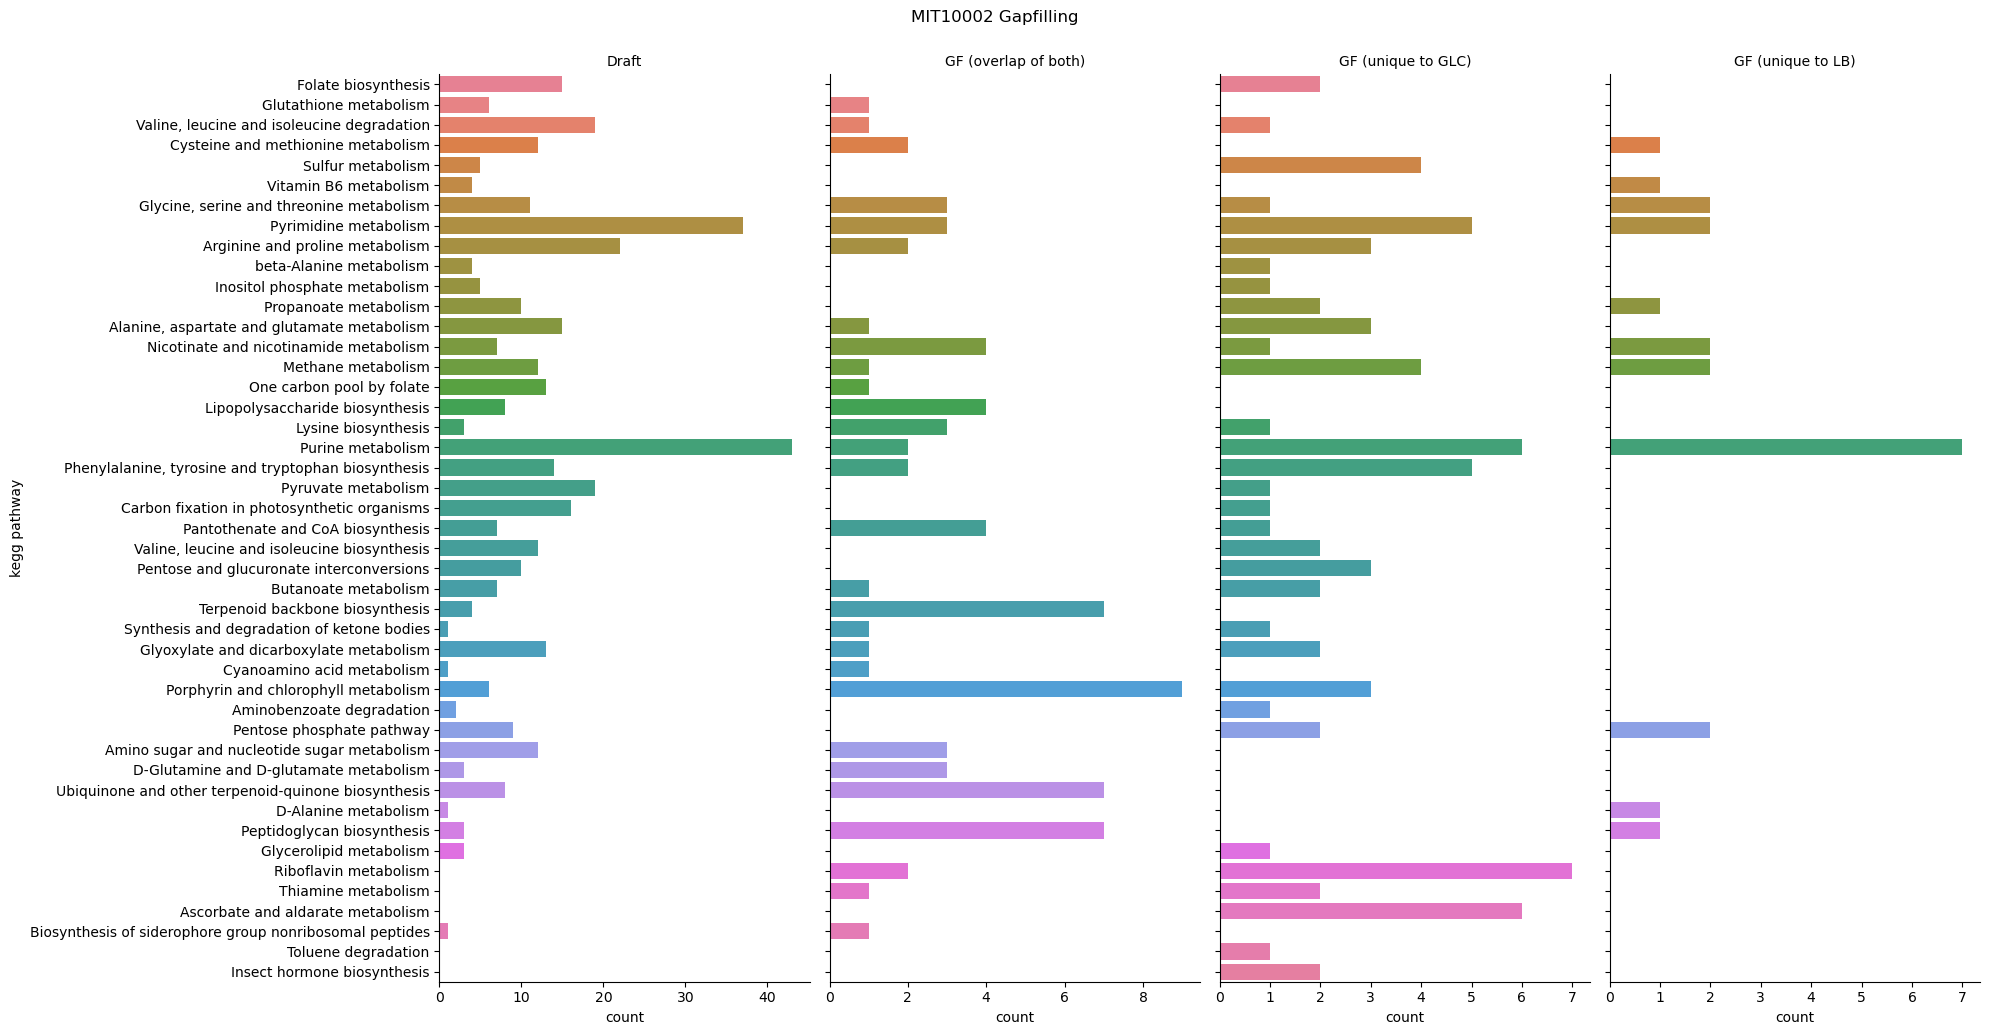

In [44]:
interesting_keggs = df_merged_lb_glc_final_explode.loc[~df_merged_lb_glc_final_explode.source.isin(['Orig']), 'kegg pathway']
sns.catplot(
    data=df_merged_lb_glc_final_explode.loc[df_merged_lb_glc_final_explode['kegg pathway'].isin(interesting_keggs)],
    col='Added By', y='kegg pathway', kind='count',
    sharex=False, 
    height=10, 
    aspect=0.5,
    hue='kegg pathway', legend=False,
).set_titles(col_template='{col_name}')
plt.suptitle('MIT10002 Gapfilling', y=1.03)

# exploration

In [ ]:
df_init = pd.read_excel(initial_model_fpath, sheet_name='ModelReactions')
df_final = pd.read_excel(final_model_fpath, sheet_name='ModelReactions')

In [ ]:
df_merge = pd.merge(df_final, df_init, on='id', how='outer', suffixes=['_final', '_init'])

In [ ]:
# gap fill reactions

In [ ]:
df_merge.loc[df_merge.direction_init.isna()]

In [ ]:
# removed reactions
df_merge.loc[df_merge.direction_final.isna()]


In [ ]:
# column changes
tmp_df_merge =df_merge.loc[~df_merge.direction_init.isna()].copy()
tmp_df_merge = tmp_df_merge.fillna('NA')
for c in df_init.columns:
    if c == 'id':
        continue
    changed_values = tmp_df_merge.loc[tmp_df_merge[f'{c}_init'] != tmp_df_merge[f'{c}_final']]
    print(c, changed_values.shape[0])

In [ ]:
c='gpr'
changed_values = tmp_df_merge.loc[tmp_df_merge[f'{c}_init'] != tmp_df_merge[f'{c}_final']]
changed_values[[f'{c}_init',f'{c}_final']]

In [ ]:
import ast
df_eggnog.KBase_rxns_draft.apply(ast.literal_eval)